In [1]:
#connect with drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My\ Drive

/content/drive/My Drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
bs = 32

In [5]:
#Load and normalize data

path_img = Path('Final_rgdata')
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FR2,FR2,FR2,FR2,FR2
Path: Final_rgdata;

Valid: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: Final_rgdata;

Test: None

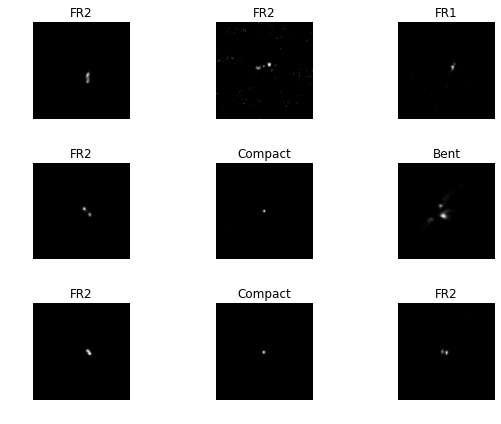

In [6]:
data.show_batch(rows=3, figsize=(8,6))

In [7]:
print(data.classes)
len(data.classes), data.c

['Bent', 'Compact', 'FR1', 'FR2']


(4, 4)

In [0]:
#define the initial architecture
learn = cnn_learner(data, models.densenet161, metrics=accuracy)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04
Min loss divided by 10: 6.03E-03


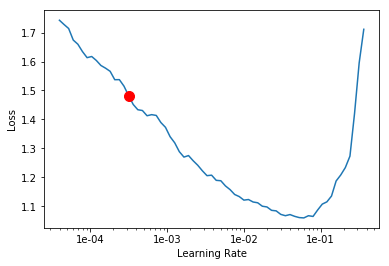

In [9]:
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.912009,0.583037,0.790000,01:53


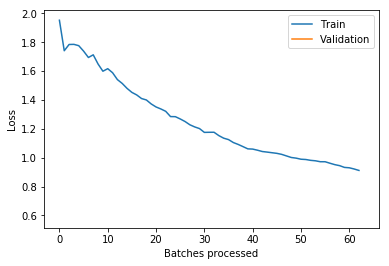

In [10]:
#train the model
learn.fit_one_cycle(1, max_lr=5e-4)
learn.save('stage1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 6.92E-05


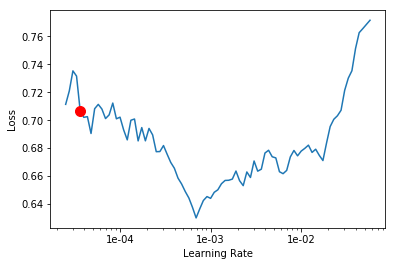

In [11]:
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.622985,0.829189,0.740000,00:53
1,0.521770,0.255957,0.907500,00:52
2,0.320280,0.184773,0.927500,00:52


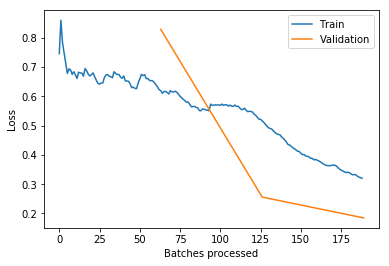

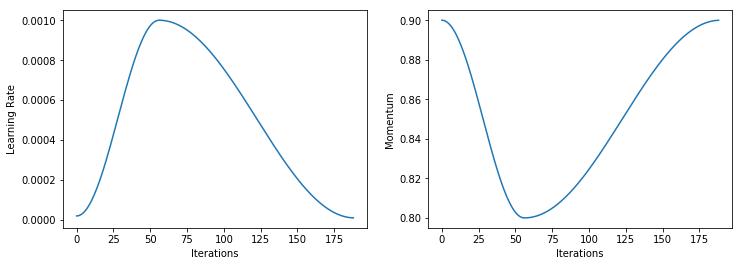

In [12]:
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.389798,0.366650,0.855000,00:53
1,0.356495,0.281599,0.877500,00:52
2,0.289093,0.376181,0.835000,00:52
3,0.268949,0.423867,0.842500,00:52
4,0.232529,0.281624,0.890000,00:52
5,0.206387,0.234741,0.907500,00:52
6,0.201343,0.186652,0.932500,00:52
7,0.159996,0.224818,0.937500,00:52
8,0.128082,0.157956,0.952500,00:52
9,0.131598,0.164034,0.962500,00:52


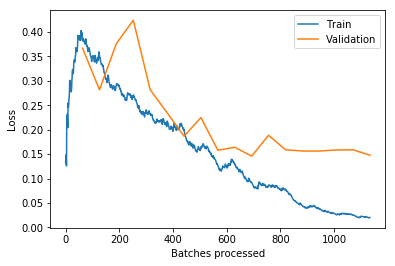

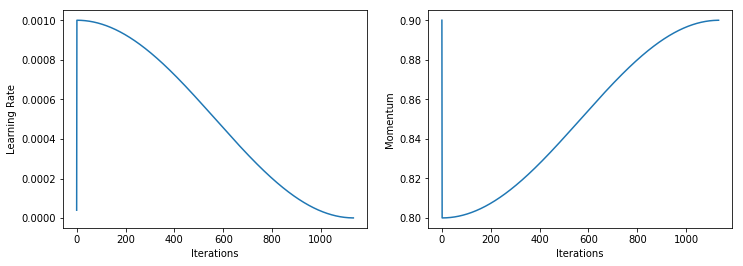

In [13]:
learn.fit_one_cycle(cyc_len=18, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

In [0]:
#save model
learn.save('d161-latest')

In [0]:
#interpret the training reults
learn.load('stage-3')
interp = ClassificationInterpretation.from_learner(learn)

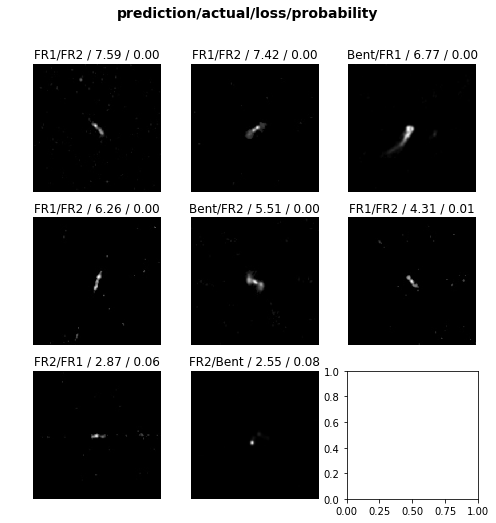

In [16]:
interp.plot_top_losses(8, figsize=(8,8))

In [17]:
interp.most_confused(min_val=2)

[('FR2', 'FR1', 5), ('FR1', 'FR2', 3), ('Bent', 'FR2', 2)]

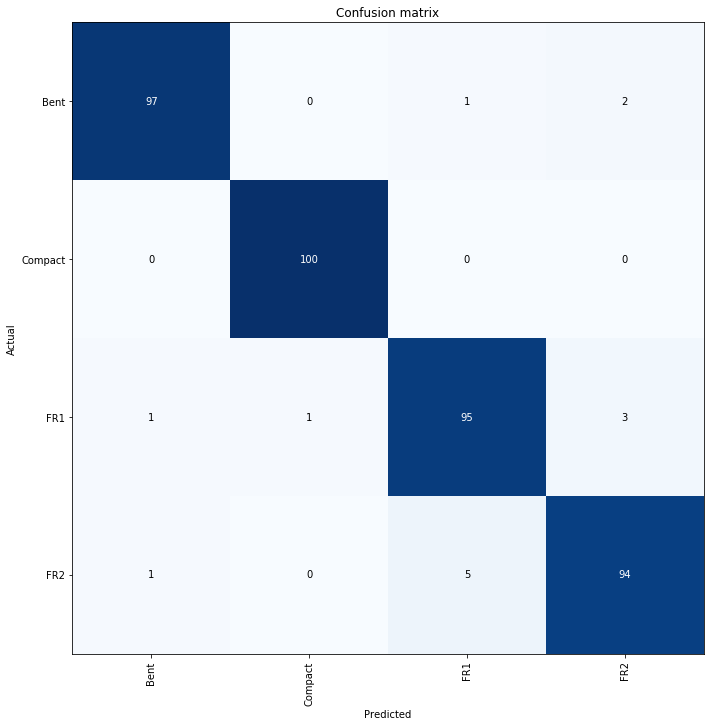

In [18]:
#get the results for the validation set
interp.plot_confusion_matrix(figsize=(10,10))

In [0]:
#export the model as pickle
learn.export('stage-3.pkl')

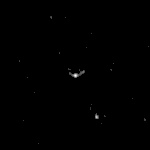

In [20]:
img = open_image('Final_rgdata/test/Bent/J003113.86+001236.2.jpeg')
img

In [21]:
#predict on a single image
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Bent

In [0]:
#optional : To optimize the model and parameter tuning
learn.lr_find()
learn.recorder.plot()

#Tweak the layers
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3)) #based on the best learning rate

In [0]:
#Optional: Save the model again, if tweaked and optimized
learn.save('Final_d161')

In [0]:
#Optional: Export the better model if optimized
learn.export('Final_d161.pkl')

In [22]:
#Testing the model

path_img = Path('Final_rgdata')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FR2,FR2,FR2,FR2,FR2
Path: Final_rgdata;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: Final_rgdata;

Test: None

In [0]:
#Get the architecture and reload the model weights
learn = cnn_learner(data, models.densenet161, metrics=accuracy)

In [0]:
learn = learn.load('stage-3')

In [0]:
#interpret for the test data
interp = ClassificationInterpretation.from_learner(learn)

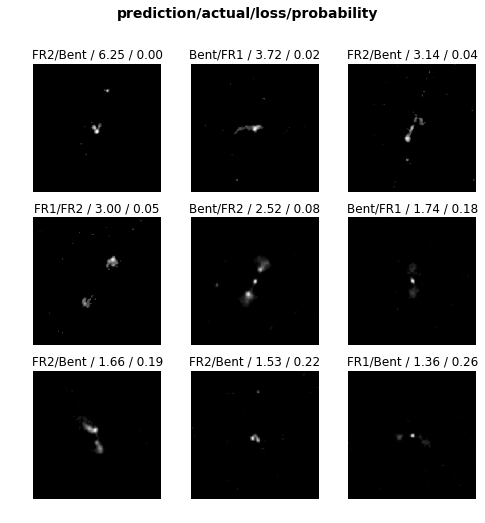

In [26]:
interp.plot_top_losses(9, figsize=(8,8))

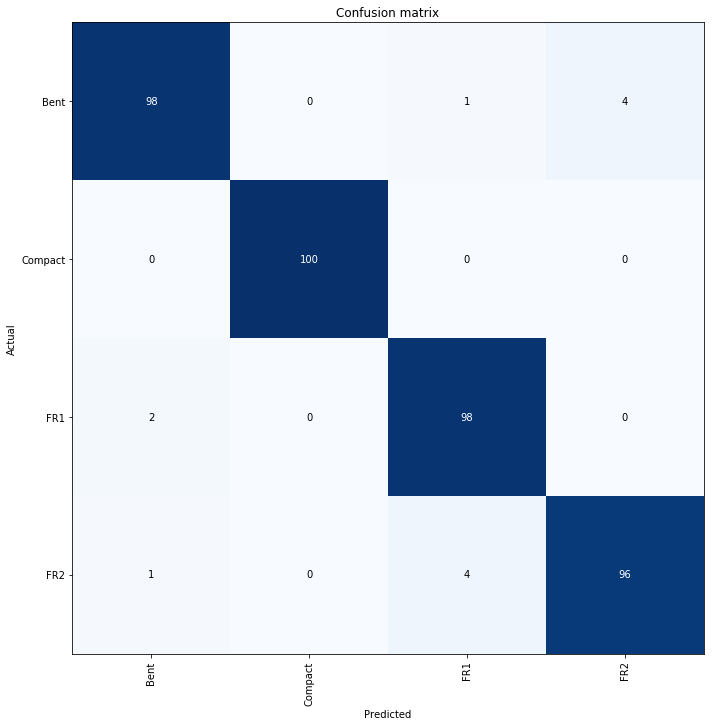

In [27]:
interp.plot_confusion_matrix(figsize=(10,10))

In [28]:
interp.most_confused(min_val=2)

[('Bent', 'FR2', 4), ('FR2', 'FR1', 4), ('FR1', 'Bent', 2)]

In [0]:
learn.export('stage-3.pkl')